In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import zscore

from config import config_sim

from neurodsp.sim import sim_noisy_bursty_oscillator
from bycycle.features import compute_features
from neurodsp.filt import filter_signal

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

# A-F. Simulate example neural signals

In [2]:
# Simulate signal
n_seconds = 1000
fs = config_sim['fs']
ratio_osc_var1 = 1
ratio_osc_var2 = 2
prob_leave_burst = .1
prob_enter_burst = .1
rdsym1 = .5
rdsym2 = .3

np.random.seed(0)
sig1, osc1, noise1 = sim_noisy_bursty_oscillator(n_seconds, fs, config_sim['freq_osc'],
                                  noise_generator='filtered_powerlaw',
                                  noise_args={'exponent': -2, 'f_range':config_sim['f_range_noise'],
                                              'filter_order':config_sim['filter_order_noise']},
                                  rdsym=rdsym1, cycle_features=config_sim['cycle_features'],
                                  ratio_osc_var=ratio_osc_var1,
                                  prob_enter_burst=prob_enter_burst, prob_leave_burst=prob_leave_burst,
                                  return_components=True)

np.random.seed(1)
sig2, osc2, noise2 = sim_noisy_bursty_oscillator(n_seconds, fs, config_sim['freq_osc'],
                                  noise_generator='filtered_powerlaw',
                                  noise_args={'exponent': -2, 'f_range':config_sim['f_range_noise'],
                                              'filter_order':config_sim['filter_order_noise']},
                                  rdsym=rdsym2, cycle_features=config_sim['cycle_features'],
                                  ratio_osc_var=ratio_osc_var2,
                                  prob_enter_burst=prob_enter_burst, prob_leave_burst=prob_leave_burst,
                                  return_components=True)

# Zscore signals
osc1 = osc1 / np.std(sig1)
noise1 = noise1 / np.std(sig1)
osc2 = osc2 / np.std(sig2)
noise2 = noise2 / np.std(sig2)
sig1 = zscore(sig1)
sig2 = zscore(sig2)

/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpre

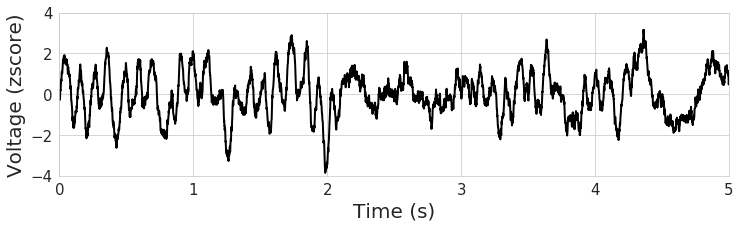

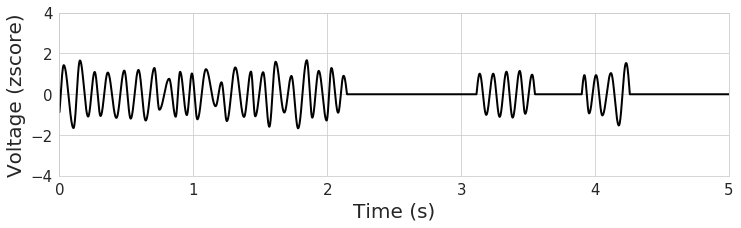

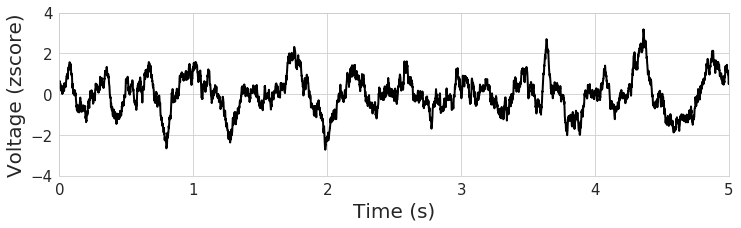

In [3]:
# Plot example time series
t = np.arange(0, len(sig1)/fs, 1/fs)
tlim = (20, 25)
tidx = np.logical_and(t >= tlim[0], t < tlim[1])

plt.figure(figsize=(12,3))
plt.plot(t[tidx] - tlim[0], sig1[tidx], 'k')
plt.xlim(0, tlim[1] - tlim[0])
plt.ylim((-4,4))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (zscore)')
plt.savefig('figs/2A_time_series_1.png', bbox_inches = "tight")

plt.figure(figsize=(12,3))
plt.plot(t[tidx] - tlim[0], osc1[tidx], 'k')
plt.xlim(0, tlim[1] - tlim[0])
plt.ylim((-4,4))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (zscore)')
plt.savefig('figs/2B_osc_1.png', bbox_inches = "tight")

plt.figure(figsize=(12,3))
plt.plot(t[tidx] - tlim[0], noise1[tidx], 'k')
plt.xlim(0, tlim[1] - tlim[0])
plt.ylim((-4,4))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (zscore)')
plt.savefig('figs/2C_noise_1.png', bbox_inches = "tight")

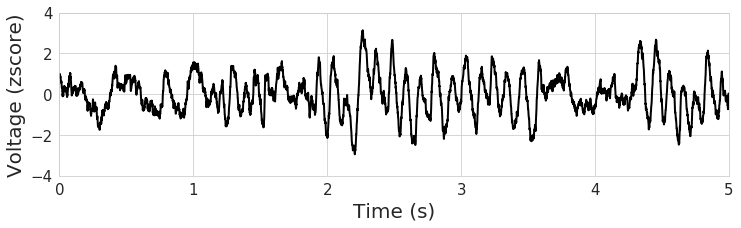

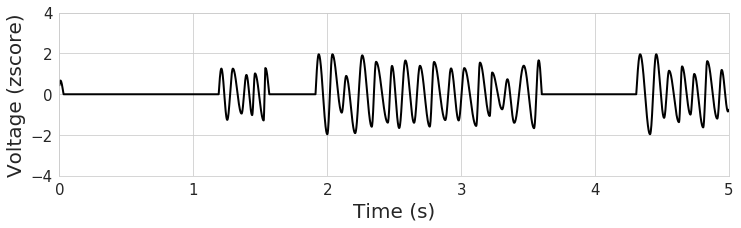

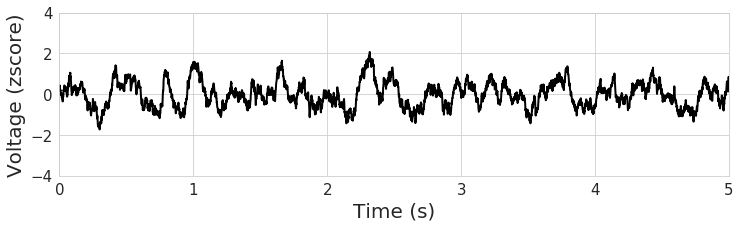

In [4]:
tlim = (15, 20)
tidx = np.logical_and(t >= tlim[0], t < tlim[1])

plt.figure(figsize=(12,3))
plt.plot(t[tidx] - tlim[0], sig2[tidx], 'k')
plt.xlim(0, tlim[1] - tlim[0])
plt.ylim((-4,4))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (zscore)')
plt.savefig('figs/2D_time_series_2.png', bbox_inches = "tight")

plt.figure(figsize=(12,3))
plt.plot(t[tidx] - tlim[0], osc2[tidx], 'k')
plt.xlim(0, tlim[1] - tlim[0])
plt.ylim((-4,4))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (zscore)')
plt.savefig('figs/2E_osc_2.png', bbox_inches = "tight")

plt.figure(figsize=(12,3))
plt.plot(t[tidx] - tlim[0], noise2[tidx], 'k')
plt.xlim(0, tlim[1] - tlim[0])
plt.ylim((-4,4))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (zscore)')
plt.savefig('figs/2F_noise_2.png', bbox_inches = "tight")

# G-J. Feature distributions

### Compute cycle-by-cycle features

In [5]:
# Apply 40Hz lowpass filters
sig1_filt = filter_signal(sig1, fs, 'lowpass', config_sim['lowpass_fc'],
                          n_seconds=config_sim['lowpass_n_seconds'],
                          remove_edge_artifacts=False)
sig2_filt = filter_signal(sig2, fs, 'lowpass', config_sim['lowpass_fc'],
                          n_seconds=config_sim['lowpass_n_seconds'],
                          remove_edge_artifacts=False)

# Set parameters for defining oscillatory bursts

# Cycle-by-cycle analysis
df1 = compute_features(sig1_filt, fs, config_sim['f_range'], center_extrema='P',
                          burst_detection_kwargs=config_sim['osc_detect_kwargs'])

df2 = compute_features(sig2_filt, fs, config_sim['f_range'], center_extrema='P',
                          burst_detection_kwargs=config_sim['osc_detect_kwargs'])

# Limit analysis only to oscillatory bursts
df1_cycles = df1[df1['is_burst']]
df2_cycles = df2[df2['is_burst']]

Transition bandwidth is 13.7 Hz. Pass/stop bandwidth is 40 Hz
Transition bandwidth is 13.7 Hz. Pass/stop bandwidth is 40 Hz


/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


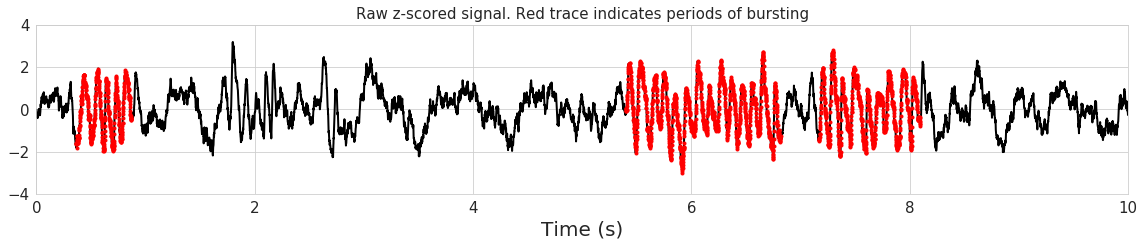

In [6]:
# Check burst detection
from bycycle.burst import plot_burst_detect_params
ax = plot_burst_detect_params(sig2, fs, df2, config_sim['osc_detect_kwargs'], tlims=(0, 10),
                              plot_only_result=True)

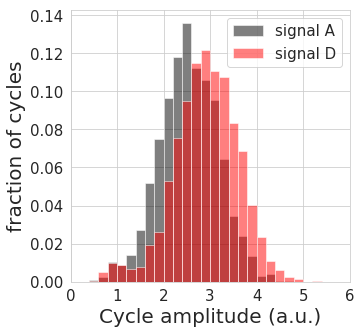

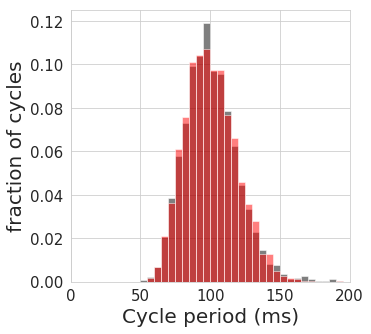

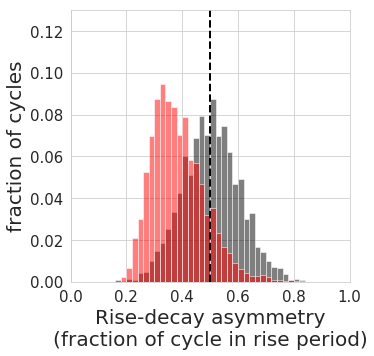

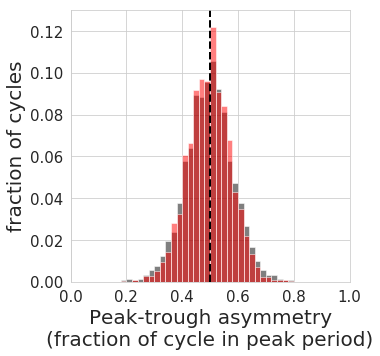

In [12]:
plt.figure(figsize=(5,5))
plt.hist(df1_cycles['volt_amp'], weights=[1/len(df1_cycles)]*len(df1_cycles),
         bins=np.arange(0, 6, .2), color='k', alpha=.5, label='signal A')
plt.hist(df2_cycles['volt_amp'], weights=[1/len(df2_cycles)]*len(df2_cycles),
         bins=np.arange(0, 6, .2), color='r', alpha=.5, label='signal D')
plt.xticks(np.arange(7))
plt.legend(fontsize=15)
plt.xlim((0,6))
plt.xlabel('Cycle amplitude (a.u.)')
plt.ylabel('fraction of cycles')
plt.savefig('figs/2G_dist_amp.png', bbox_inches = "tight")

plt.figure(figsize=(5,5))
plt.hist(df1_cycles['period'] / fs * 1000, weights=[1/len(df1_cycles)]*len(df1_cycles),
         bins=np.arange(0, 200, 5), color='k', alpha=.5)
plt.hist(df2_cycles['period'] / fs * 1000, weights=[1/len(df2_cycles)]*len(df2_cycles),
         bins=np.arange(0, 200, 5), color='r', alpha=.5)
plt.xlim((0,200))
plt.xlabel('Cycle period (ms)')
plt.ylabel('fraction of cycles')
plt.savefig('figs/2H_dist_period.png', bbox_inches = "tight")

plt.figure(figsize=(5,5))
plt.hist(df1_cycles['time_rdsym'], weights=[1/len(df1_cycles)]*len(df1_cycles),
         bins=np.arange(0, 1, .02), color='k', alpha=.5)
plt.hist(df2_cycles['time_rdsym'], weights=[1/len(df2_cycles)]*len(df2_cycles),
         bins=np.arange(0, 1, .02), color='r', alpha=.5)
plt.plot([.5, .5], [0, .13], 'k--')
plt.ylim(0, .13)
plt.xlim((0,1))
plt.xlabel('Rise-decay asymmetry\n(fraction of cycle in rise period)')
plt.ylabel('fraction of cycles')
plt.savefig('figs/2I_dist_rdsym.png', bbox_inches = "tight")

plt.figure(figsize=(5,5))
plt.hist(df1_cycles['time_ptsym'], weights=[1/len(df1_cycles)]*len(df1_cycles),
         bins=np.arange(0, 1, .02), color='k', alpha=.5)
plt.hist(df2_cycles['time_ptsym'], weights=[1/len(df2_cycles)]*len(df2_cycles),
         bins=np.arange(0, 1, .02), color='r', alpha=.5)
plt.plot([.5, .5], [0, .13], 'k--')
plt.ylim(0, .13)
plt.xlim((0,1))
plt.xlabel('Peak-trough asymmetry\n(fraction of cycle in peak period)')
plt.ylabel('fraction of cycles')
plt.savefig('figs/2J_dist_ptsym.png', bbox_inches = "tight")

In [8]:
# Print means of each distribution
for feat in ['volt_amp', 'period', 'time_rdsym', 'time_ptsym']:
    print('sig 1 mean {:12s}: {:.2f}'.format(feat, df1_cycles[feat].mean()))
    print('sig 2 mean {:12s}: {:.2f}'.format(feat, df2_cycles[feat].mean()))

sig 1 mean volt_amp    : 2.54
sig 2 mean volt_amp    : 2.90
sig 1 mean period      : 100.28
sig 2 mean period      : 100.16
sig 1 mean time_rdsym  : 0.50
sig 2 mean time_rdsym  : 0.38
sig 1 mean time_ptsym  : 0.50
sig 2 mean time_ptsym  : 0.50
